In [1]:
import cv2

import os
import sys
import pickle

sys.path.append('../..')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from lib.dataloaders import imread
from lib.datasets import patches_path, wsi_csv_path, patches_clean90_pkl_path, max_lbl_nums

In [2]:
patch_sz = 128

colors = {
    'radboud': {0: '#ffffff',
                1: '#8080ff',
                2: '#80ff80',
                3: '#ff8080',                
                4: '#ff4040',                
                5: '#ff0000'},
    'karolinska': {0: '#ffffff',
                   1: '#808080',
                   2: '#ff0000'},
}

def hex2rgb(h):
    h = h.lstrip('#')
    return [int(h[i:i+2], 16) for i in (0, 2, 4)]

In [3]:
df = pd.read_csv(wsi_csv_path)
with open(patches_clean90_pkl_path, 'rb') as f:
    p_dict = pickle.load(f)

In [8]:
list(p_dict.keys())

['000920ad0b612851f8e01bcc880d9b3d',
 '0018ae58b01bdadc8e347995b69f99aa',
 '001c62abd11fa4b57bf7a6c603a11bb9',
 '0005f7aaab2800f6170c399693a96917',
 '002a4db09dad406c85505a00fb6f6144',
 '003046e27c8ead3e3db155780dc5498e',
 '003a91841da04a5a31f808fb5c21538a',
 '0032bfa835ce0f43a92ae0bbab6871cb',
 '001d865e65ef5d2579c190a0e0350d8f',
 '00412139e6b04d1e1cee8421f38f6e90',
 '004dd32d9cd167d9cc31c13b704498af',
 '0068d4c7529e34fd4c9da863ce01a161',
 '006f6aa35a78965c92fffd1fbd53a058',
 '003d4dd6bd61221ebc0bfb9350db333f',
 '004f6b3a66189b4e88b6a01ba19d7d31',
 '004391d48d58b18156f811087cd38abf',
 '007433133235efc27a39f11df6940829',
 '006f4d8d3556dd21f6424202c2d294a9',
 '0076bcb66e46fb485f5ba432b9a1fe8a',
 '008069b542b0439ed69b194674051964',
 '00951a7fad040bf7e90f32e81fc0746f',
 '00a76bfbec239fd9f465d6581806ff42',
 '008308f099f0c565fbc024ece6b8b08c',
 '005e66f06bce9c2e49142536caf2f6ee',
 '00a26aaa82c959624d90dfb69fcf259c',
 '00a7fb880dc12c5de82df39b30533da9',
 '00bbc1482301d16de3ff63238cfd0b34',
 

In [26]:
image_id = '198fa06f052feedc1684e42829c137fc'

In [27]:
rows = p_dict[image_id]

In [28]:
df[df['image_id'] == image_id]

,image_id,data_provider,isup_grade,gleason_score
996,198fa06f052feedc1684e42829c137fc,radboud,1,3+3


In [29]:
ys = []
xs = []
for row in rows:
    (_, image_id, data_provider, isup_grade, gleason_score, y, x, *_) = row
    ys.append(y)
    xs.append(x)

In [30]:
min_y, min_x = min(ys), min(xs)
width = max(ys) - min(ys) + 1
height = max(xs) - min(xs) + 1

In [31]:
width, height

(36, 12)

In [32]:
wsi_img = np.full((width*patch_sz, height *patch_sz, 3), (255, 255, 255), dtype=np.uint8)
wsi_img_mask = np.full((width*patch_sz, height *patch_sz, 3), (255, 255, 255), dtype=np.uint8)

for row in tqdm(rows):
    (_, image_id, data_provider, isup_grade, gleason_score, y, x, *_) = row
    fname = f"{image_id}_{y}_{x}"
    p_img = imread(os.path.join(patches_path, f"imgs/{fname}.jpeg"))
    
    r_img = imread(os.path.join(patches_path, f"masks/{fname}.png"))[..., 0]
    m_img = np.zeros_like(p_img)
    for i in range(max_lbl_nums):
        k = r_img == i
        if k.sum() > 0:
            m_img[k] = hex2rgb(colors[data_provider][i])    

    p_img = cv2.resize(p_img, (patch_sz, patch_sz))            
    m_img = cv2.resize(m_img, (patch_sz, patch_sz))
    
    y -= min_y
    x -= min_x
    wsi_img[y*patch_sz:(y+1)*patch_sz, x*patch_sz:(x+1)*patch_sz] = p_img
    wsi_img_mask[y*patch_sz:(y+1)*patch_sz, x*patch_sz:(x+1)*patch_sz] = m_img

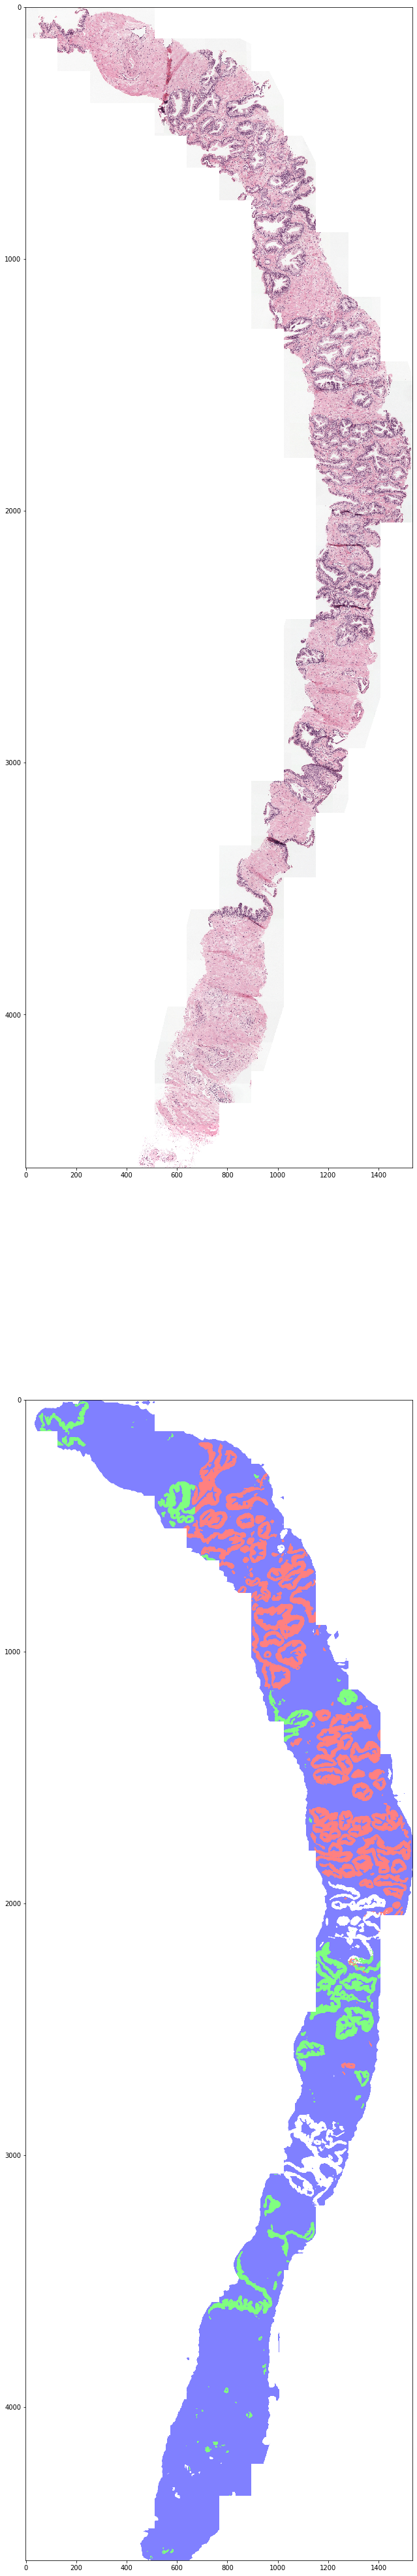

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(36, 72))
axs[0].imshow(wsi_img);
axs[1].imshow(wsi_img_mask);

In [34]:
from skimage.io import imsave

In [35]:
imsave("../../wsi_sample.png", wsi_img)